In [50]:
import tensorflow as tf 
from tensorflow.keras import models , layers
import matplotlib.pyplot as plt
import os
import numpy

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [3]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 0 1 1 0 1 0 0 1 1 0 0 1 0 0 1 0 1 2 0 1 0 0 0 0 1 1 1 1 2]


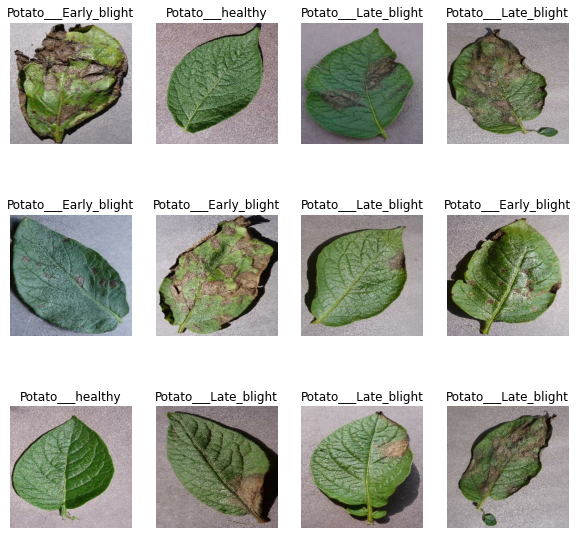

In [6]:
# showing the image 
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

68

we are going to keep 

80% data ---> training

20% data ---> 10% => validation
              10% => testing

In [8]:
def dataset_partition(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = dataset_partition(dataset)

In [10]:
print(len(train_ds), len(val_ds), len(test_ds))

54 6 8


In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [12]:
resize_and_rescaling = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescaling,
    data_augmentation,
    
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax')
])

model.build(input_shape = input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [15]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [16]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/10
54/54 [==============================] - 231s 4s/step - loss: 0.8518 - accuracy: 0.5544 - val_loss: 0.7786 - val_accuracy: 0.6771
Epoch 2/10
54/54 [==============================] - 168s 3s/step - loss: 0.6568 - accuracy: 0.7130 - val_loss: 0.6398 - val_accuracy: 0.7448
Epoch 3/10
54/54 [==============================] - 181s 3s/step - loss: 0.5102 - accuracy: 0.7679 - val_loss: 0.4978 - val_accuracy: 0.7969
Epoch 4/10
54/54 [==============================] - 181s 3s/step - loss: 0.4425 - accuracy: 0.8056 - val_loss: 0.6227 - val_accuracy: 0.7344
Epoch 5/10
54/54 [==============================] - 160s 3s/step - loss: 0.3468 - accuracy: 0.8536 - val_loss: 0.3141 - val_accuracy: 0.8438
Epoch 6/10
54/54 [==============================] - 183s 3s/step - loss: 0.2066 - accuracy: 0.9155 - val_loss: 0.1391 - val_accuracy: 0.9531
Epoch 7/10
54/54 [==============================] - 172s 3s/step - loss: 0.1630 - accuracy: 0.9369 - val_loss: 0.2357 - val_accuracy: 0.9167
Epoch 8/10
54

In [17]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 9s 776ms/step - loss: 0.6131 - accuracy: 0.8242


In [18]:
scores

[0.613101065158844, 0.82421875]

In [19]:
history

In [20]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

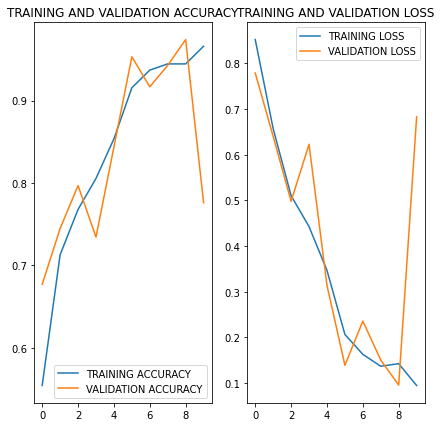

In [24]:
plt.figure(figsize = (7,7))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'TRAINING ACCURACY')
plt.plot(range(EPOCHS), val_acc, label = 'VALIDATION ACCURACY')
plt.legend(loc = 'lower right')
plt.title('TRAINING AND VALIDATION ACCURACY')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'TRAINING LOSS')
plt.plot(range(EPOCHS), val_loss, label = 'VALIDATION LOSS')
plt.legend(loc = 'upper right')
plt.title('TRAINING AND VALIDATION LOSS')
plt.show()

FIRST IMAGE TO PREDICT :
ACTUAL IMAGE : Potato___Late_blight
PREDICED LABEL : Potato___Late_blight


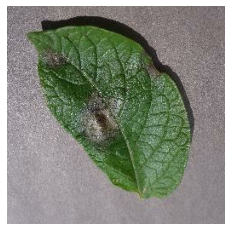

In [33]:
for image_batches, label_batches in test_ds.take(1):
    first_image = image_batches[0].numpy().astype('uint8')
    first_label = label_batches[0].numpy()
    
    print('FIRST IMAGE TO PREDICT :')
    plt.imshow(first_image)
    plt.axis('off')
    print('ACTUAL IMAGE :', class_names[first_label])
    
    batch_prediction = model.predict(image_batches)
    batch_prediction = class_names[np.argmax(batch_prediction[0])]
    print('PREDICED LABEL :',batch_prediction)

In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

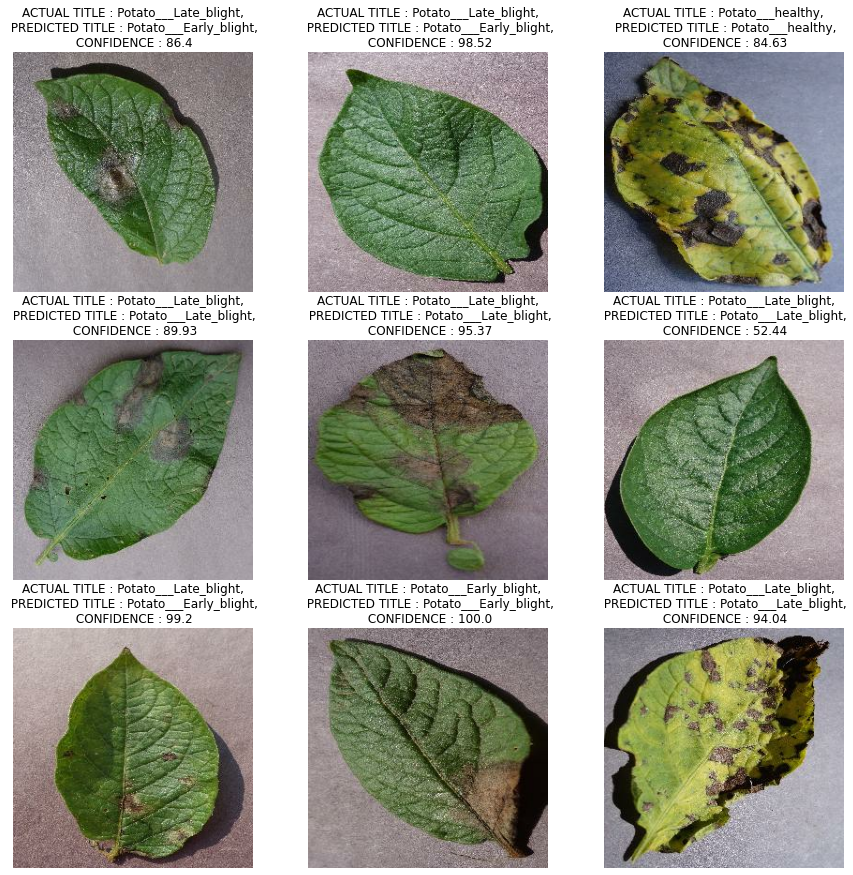

In [45]:
plt.figure(figsize = (15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i +1)
        plt.imshow(image_batches[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f'ACTUAL TITLE : {actual_class},\n PREDICTED TITLE : {predicted_class},\n CONFIDENCE : {confidence}')
        plt.axis('off')

In [52]:
model_version = max([int(i) for i in os.listdir('../models') + [0]]) +1

In [53]:
model.save(f"../models/{model_version}/model_trained_{model_version}.h5")